## Audio Processing Notebook

### Introduction:-
# This notebook demonstrates how to use the `AudioProcessor` class for various audio processing tasks such as detecting noise, reducing noise , and removing silence.

### Setup:-
# Import the necessary libraries and define the `AudioProcessor` class.

In [6]:
import numpy as np
import librosa
import noisereduce as nr
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define the AudioProcessor class


In [7]:
class AudioProcessor:
    def __init__(self, dataframe):
        self.data = dataframe

    def read_audio(self, filepath, sr=None):
        """
        Read audio file from filepath using librosa.

        Parameters:
        - filepath (str): Path to the audio file.
        - sr (int or None): Sampling rate to load the audio file (optional).

        Returns:
        - audio (np.ndarray): Loaded audio data.
        - sr (int): Sampling rate of the loaded audio.
        """
        audio, sr = librosa.load(filepath, sr=sr)
        return audio, sr

    def detect_noise(self, audio, sr, threshold=0.02):
        """
        Detect noise in audio.

        Parameters:
        - audio (np.ndarray): Audio data.
        - sr (int): Sampling rate of the audio.
        - threshold (float): Threshold ratio to determine noise (optional).

        Returns:
        - bool: True if noise is detected, False otherwise.
        """
        reduced_noise = nr.reduce_noise(y=audio, sr=sr)
        noise = audio - reduced_noise
        noise_energy = np.sum(noise ** 2)
        audio_energy = np.sum(audio ** 2)
        noise_ratio = noise_energy / audio_energy
        return noise_ratio > threshold

    def remove_silence(self, audio_path, output_path):
        """
        Remove silence from audio file using pydub and save to output_path.

        Parameters:
        - audio_path (str): Path to the input audio file.
        - output_path (str): Path where the processed audio file will be saved.
        """
        audio = AudioSegment.from_file(audio_path, format="wav")
        nonsilent_chunks = detect_nonsilent(audio, min_silence_len=500, silence_thresh=-40)
        
        nonsilent_audio = AudioSegment.empty()
        for start, end in nonsilent_chunks:
            nonsilent_audio += audio[start:end]
        
        nonsilent_audio.export(output_path, format="wav")
        print(f"Silence removed using pydub. Output saved at {output_path}")

    def process_all_files_remove_silence(self, output_dir):
        """
        Process all audio files listed in the dataset to remove silence and save them to the specified output directory.

        Parameters:
            - output_dir (str): Path to the directory where the processed audio files will be saved.

        This method iterates through each row in the dataset, extracts the audio file path, processes the file to remove silence, 
        and saves the processed file to the output directory. The processing is done using the `remove_silence` method.
        """
        for index, row in self.data.iterrows():
            audio_path = row['audio_path']
            output_path = os.path.join(output_dir, os.path.basename(audio_path))
            
            print(f"Processing file: {audio_path}")
            self.remove_silence(audio_path, output_path)
    
    def plot_waveforms(self, original_audio_path, processed_audio_path):
        """
        Plot the waveforms of the original and processed audio files.

        Parameters:
        - original_audio_path (str): Path to the original audio file.
        - processed_audio_path (str): Path to the processed audio file.
        """
        # Load original audio
        original_audio, sr = self.read_audio(original_audio_path)
        
        # Load processed audio
        processed_audio, _ = self.read_audio(processed_audio_path)
        
        # Plot waveforms
        plt.figure(figsize=(14, 8))

        plt.subplot(2, 1, 1)
        librosa.display.waveshow(original_audio, sr=sr)
        plt.title('Original Audio')

        plt.subplot(2, 1, 2)
        librosa.display.waveshow(processed_audio, sr=sr)
        plt.title('Processed Audio (Silence Removed)')

        plt.tight_layout()
        plt.show()


# Test on sample

Processing file: ./Data/train/train_sample_0.wav
Silence removed using pydub. Output saved at ./Data/Clean_Data/train_sample_0.wav
Processing file: ./Data/train/train_sample_1.wav
Silence removed using pydub. Output saved at ./Data/Clean_Data/train_sample_1.wav
Processing file: ./Data/train/train_sample_2.wav
Silence removed using pydub. Output saved at ./Data/Clean_Data/train_sample_2.wav
Processing file: ./Data/train/train_sample_3.wav
Silence removed using pydub. Output saved at ./Data/Clean_Data/train_sample_3.wav
Processing file: ./Data/train/train_sample_4.wav
Silence removed using pydub. Output saved at ./Data/Clean_Data/train_sample_4.wav
Processing file: ./Data/train/train_sample_5.wav
Silence removed using pydub. Output saved at ./Data/Clean_Data/train_sample_5.wav
Processing file: ./Data/train/train_sample_6.wav
Silence removed using pydub. Output saved at ./Data/Clean_Data/train_sample_6.wav
Processing file: ./Data/train/train_sample_7.wav
Silence removed using pydub. Outpu

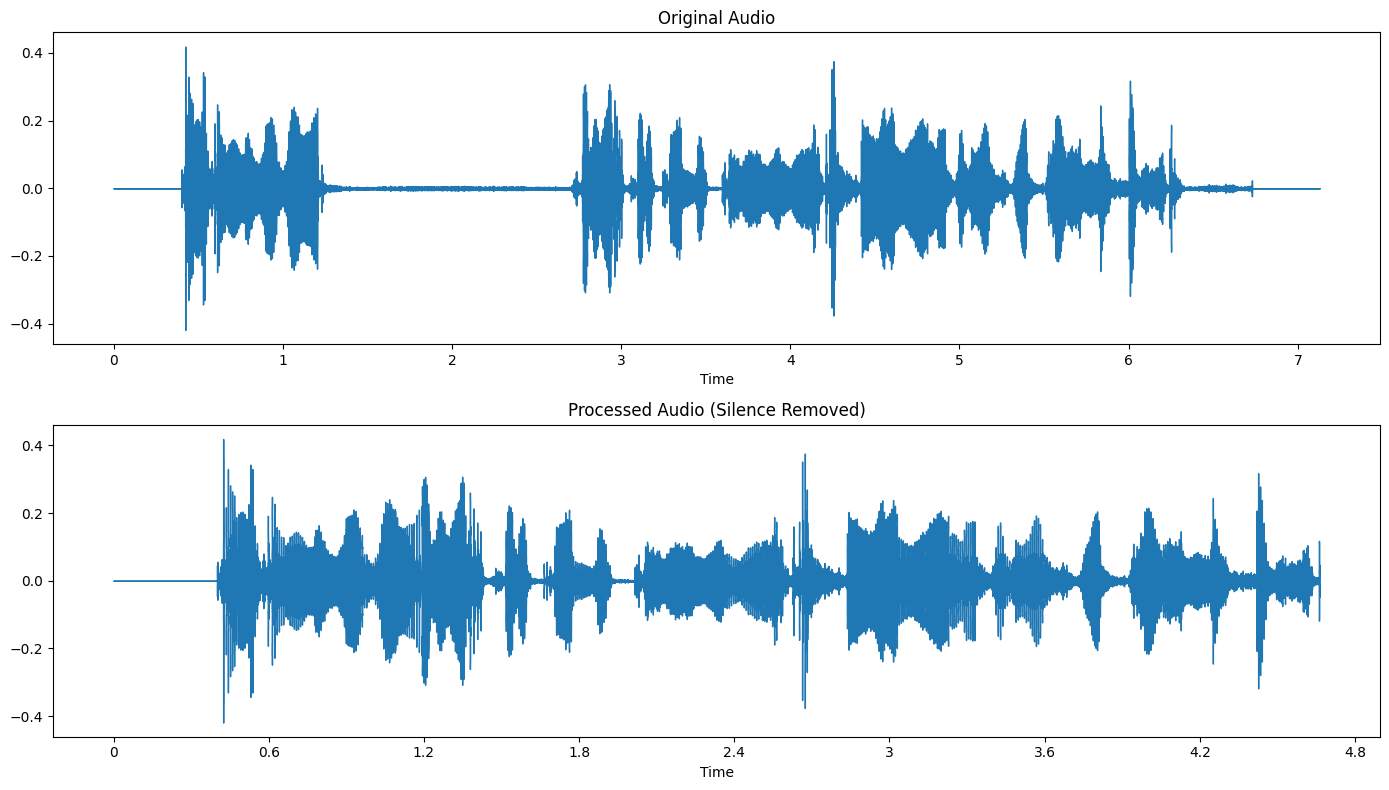

In [10]:
# Load CSV files
# adapt_df = pd.read_csv('')
train_df = pd.read_csv('./Data/train.csv')

# Add the directory path to the audio file names
# adapt_audio_dir = 'adapt/'
train_audio_dir = './Data/train/'

# adapt_df['audio_path'] = adapt_df['audio'].apply(lambda x: os.path.join(adapt_audio_dir, x + '.wav'))
train_df['audio_path'] = train_df['audio'].apply(lambda x: os.path.join(train_audio_dir, x + '.wav'))

output_audio_dir = './Data/Clean_Data'


if not os.path.exists(output_audio_dir):
    os.makedirs(output_audio_dir)
    
audio_processor = AudioProcessor(train_df[:10])

# Process all files to remove silence and save to the output directory
audio_processor.process_all_files_remove_silence(output_audio_dir)

# Plot waveforms before and after processing for the first audio file
original_audio_path = train_df['audio_path'][0]
processed_audio_path = os.path.join(output_audio_dir, os.path.basename(original_audio_path))
audio_processor.plot_waveforms(original_audio_path, processed_audio_path)
